# Фабарисов Дмитрий 2 курс АД. Графические модели. Практика 1

In [182]:
import numpy as np
import matplotlib.pyplot as plt
import time
import skimage.io as sk
from copy import deepcopy as cp

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. Генерация порождающей матрицы G по проверочной H

Функция set_eye_column(matrix, column) вычитает строку под номером column матрицы matrix из всех остальных строк, чтобы столбец column стал столбцом единичной матрица с единственным ненулевым элементом matrix[column, column]

In [68]:
def set_eye_column(matrix, column, fixed_row):
    row_number = matrix.shape[0]
    for row_idx in range(row_number):
        if (row_idx != fixed_row and matrix[row_idx, column] != 0):
            matrix[row_idx] = (matrix[row_idx] + matrix[fixed_row]) % 2

Функция find_nonzero_row(matrix, column, except_rows) находит первую строку с ненулевым элементом в строке column начиная с next_row. строки с номерами из except_rows пропускаются

In [69]:
def find_nonzero_row(matrix, column, next_row, except_rows):
    row_number = matrix.shape[0]
    while (matrix[next_row, column] == 0 or next_row in except_rows):
        next_row += 1
        if (next_row >= row_number):
            return row_number
    return next_row

In [70]:
def make_generator_matrix(H):
    row_number, column_number = H.shape
    cur_H = H.copy()
    H_eye_row_permutation = list()
    H_eye_columns = list()
    for column in range(column_number):
        nonzero_row = find_nonzero_row(cur_H, column, 0, H_eye_row_permutation)
        if (nonzero_row >= row_number):
            continue
        H_eye_row_permutation.append(nonzero_row) # сохраняем индексы строк
        H_eye_columns.append(column)  # сохраняем индексы столбцов
        set_eye_column(cur_H, column, nonzero_row)
    G_P_row_indexes = np.zeros(row_number)
    G_P_row_indexes[H_eye_row_permutation] = H_eye_columns
    G_eye_row_indexes = [i for i in range(column_number) if i not in G_P_row_indexes]
    P_width = column_number - row_number
    G = np.zeros((column_number, P_width))
    G[G_eye_row_indexes, :] = np.eye(P_width)
    G[G_P_row_indexes.astype(int), :] = cur_H[:, G_eye_row_indexes]
    return G, np.array(G_eye_row_indexes).astype(int)

# 1. Тесты

In [71]:
H = np.array([[0, 1, 0, 1, 1, 0, 1, 1], [0, 1, 0, 1, 1, 1, 1, 0], [1, 0, 1, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 1, 1]])
print H

[[0 1 0 1 1 0 1 1]
 [0 1 0 1 1 1 1 0]
 [1 0 1 0 1 0 1 1]
 [1 0 1 1 0 0 1 1]]


In [72]:
G = make_generator_matrix(H)

In [73]:
print H.dot(G[0]) % 2

[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


# 2. Эффектиное декодирование

Функция инициализации задает:  
- массивы для хранения сообщений из вершин в факторы (mu_v_f), изначально инициализируя значениями $p(e_i)$. Те вершины, которые не входят в $j$-тый фактор, шлют туда нулевые сообщения  
- массивы для хранения сообщений из факторов в вершины (mu_f_v)  
- массивы для маргинальных распределений  
- массивы для хранения различных ошибок

In [74]:
def initialize(H, q):
    row_number, column_number = H.shape
    
    # из вершин в факторы
    mu_v_f = np.zeros((column_number, row_number, 2)) 
    mu_v_f[:, :, 1] = q * H.T
    mu_v_f[:, :, 0] = (1 - q) * H.T
    
    # из факторов в вершины
    mu_f_v = np.zeros((row_number, column_number, 2)) 
    
    beliefs = np.zeros((column_number, 2))
    old_beliefs = np.zeros((column_number, 2))
    
    e = np.zeros(column_number) # вектор текущих ошибок
    e_progress = list() # список векторов ошибок в зависимости от итерации
    stable_beliefs = list() # доля стабилизировавшихся ошибок в зависимости от итерации
    
    return row_number, column_number, mu_v_f, mu_f_v, beliefs, old_beliefs, e, e_progress, stable_beliefs

Функция обновления массива сообщений для вершины $i$ в фактор $j$ (mu_v_f). В точности как в задании

In [75]:
def update_mu_v_f(H, q, mu_f_v, mu_v_f, damping, i, j):
    # факторы-соседи i кроме j
    i_neighbors = [item for item in np.nonzero(H[:, i])[0] if item != j]
    
    mu_new = np.zeros(2)
    mu_new[0] = np.prod(mu_f_v[i_neighbors, i, 0]) * (1 - q)
    mu_new[1] = np.prod(mu_f_v[i_neighbors, i, 1]) * q
    mu_new /= np.sum(mu_new)
    
    mu_v_f[i, j, 0] = damping * mu_new[0] + (1 - damping) * mu_v_f[i, j, 0]
    mu_v_f[i, j, 1] = damping * mu_new[1] + (1 - damping) * mu_v_f[i, j, 1]

Функция обновления массива сообщений для фактора $j$ в вершину $i$ (mu_f_v). В точности как в задании

In [76]:
def update_mu_f_v(s, H, q, mu_f_v, mu_v_f, damping, j, i):
        
    # вершины, кроме i, входящие в фактор j
    j_neighbors = [item for item in np.nonzero(H[j])[0] if item != i] 
    
    delta_mu_v_f_j = mu_v_f[:, j, 0] - mu_v_f[:, j, 1]
    delta_p = np.prod([delta_mu_v_f_j[k] for k in j_neighbors])
    
    # выразили из системы
    p = 0.5 * np.array([1 + delta_p, 1 - delta_p]) 
    
    # пересчет сообщений (меньше damping - меньше обновляется)
    mu_f_v[j, i, 0] = damping * p[s[j]] + (1 - damping) * mu_f_v[j, i, 0]
    mu_f_v[j, i, 1] = damping * p[1 - s[j]] + (1 - damping) * mu_f_v[j, i, 1]


Обновление оценок на маргинальные распределения

In [77]:
def update_beliefs(H, q, mu_f_v, beliefs, i):
    i_neighbors = np.nonzero(H[:, i])[0]
    beliefs[i, 0] = np.prod(mu_f_v[i_neighbors, i, 0]) * (1 - q)
    beliefs[i, 1] = np.prod(mu_f_v[i_neighbors, i, 1]) * q

In [78]:
def get_stable_beliefs_rate(beliefs, old_beliefs, tol_beliefs):
    diff = np.absolute(beliefs - old_beliefs)
    number_stable = len(np.where(diff < tol_beliefs)[0])
    return number_stable / len(old_beliefs) / 2.0

In [79]:
def update_e(H, s, old_beliefs, beliefs, display, tol_beliefs):
    e = np.argmax(beliefs, axis=1)
    result = 2
    if display:
        print 'e', e
    if np.all(H.dot(e) == s):
        return e, 0
    if np.linalg.norm(beliefs - old_beliefs) / np.linalg.norm(beliefs) < tol_beliefs:
        return e, 1
    return e, 2

Функция декодирования  
ВХОД  
$s$ – наблюдаемый синдром, numpy array, бинарный вектор длины m;  
$H$ – проверочная матрица кода, numpy array, бинарная матрица размера m×n;  
$q$ – вероятность инверсии бита при передаче по каналу связи, число от 0 до 1/2;  
$schedule$ – расписание пересчёта сообщений, возможные значения ’parallel’ и ’sequential’;  
$damping$ – коэффициент дэмпфирования при пересчёте сообщений, число от 0 до 1;  
$max\_iter$ – максимальное число итераций алгоритма декодирования;  
$tol\_beliefs$ – порог стабилизации для beliefs, число;  
$display$ – режим отображения, True или False, если True, то отображается промежуточная информация на итерациях  
ВЫХОД  
$e$ – восстановленный вектор ошибок, бинарный вектор-столбец длины n;  
$status$ – результат декодирования:  
- 0, если найден вектор e, соответствующий входному синдрому s,  
- 1, если произошла стабилизация значений beliefs,  
- 2, если произошёл выход по максимальному числу итераций.  

In [166]:
def decode(s, H, q, schedule = 'parallel', damping = 1, max_iter = 40, tol_beliefs = 1e-4, display = False):
    
    row_number, column_number, mu_v_f, mu_f_v, beliefs, old_beliefs, e, e_progress, stable_beliefs = initialize(H, q)
    result = 2
        
    for iter in range(max_iter):
        if schedule == 'parallel':
            
            # все факторы посылают сообщения во все вершины
            flag = 1
            for j in range(row_number):
                for i in np.nonzero(H[j])[0]:
                    update_mu_f_v(s, H, q, mu_f_v, mu_v_f, damping, j, i)
                    
            old_beliefs = beliefs.copy()
            # все вершины посылают сообщения во все факторы
            for i in range(column_number):
                update_beliefs(H, q, mu_f_v, beliefs, i)
                for j in np.nonzero(H[:, i])[0]:
                    update_mu_v_f(H, q, mu_f_v, mu_v_f, damping, i, j)

        if schedule == 'sequential':
            for i in range(column_number):
                # данной вершины сначала вычисляются все входящие сообщения от соседних факторов
                for j in np.nonzero(H[:, i])[0]:
                    update_mu_f_v(s, H, q, mu_f_v, mu_v_f, damping, j, i)
                old_beliefs = beliefs.copy()
                update_beliefs(H, q, mu_f_v, beliefs, i)
                
                # вычисляются все исходящие сообщения в соседние факторы
                for j in np.nonzero(H[:, i])[0]:
                    update_mu_v_f(H, q, mu_f_v, mu_v_f, damping, i, j)
        
        stable_beliefs.append(get_stable_beliefs_rate(beliefs, old_beliefs, tol_beliefs))
        e, result = update_e(H, s, old_beliefs, beliefs, display, tol_beliefs)
        e_progress.append(e)
        if result != 2:
            break
            
    return e, result, e_progress, stable_beliefs

# 2. Тесты

Оставим только самый наглядный тест, реальных тестов было гораздо больше

## 2.1 Вспомогательные функции

In [81]:
def show_pic(pic_list, name = ['picture']*100, figsize_ = (20, 8)):
    fig = figure(figsize = figsize_)
    for idx in range(len(pic_list)):
        subplot = fig.add_subplot(1, len(pic_list), idx+1)
        sk.imshow(pic_list[idx], cmap = 'gray')
        subplot.set_title(name[idx])

In [302]:
def generate_H(row_number, column_number, ones_number=4):
    H = np.zeros((row_number, column_number))

    for i in range(row_number):
        j = np.random.permutation(np.arange(column_number))[:ones_number]
        H[i, j] = 1

    return H.astype(int)

In [83]:
def get_noise(size, q):
    v_noise = np.random.binomial(1, q, size)
    return v_noise

## 2.2 Подготовка картинки и создание избыточного кода

При отображении сообщения переставим строки так, чтобы сверху была картинка

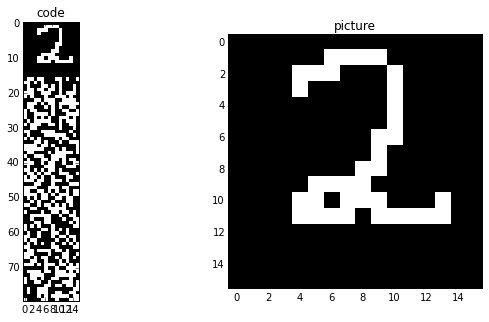

In [84]:
pic_16 = sk.imread("2_16.png")
pic_16[pic_16 == 255] = 1

l = len(pic_16.flatten())
H_size = (4*l, 5*l)

H = generate_H(*H_size)
G = make_generator_matrix(H)
v = G[0].dot(pic_16.flatten()) % 2

v_show_indeces = list(G[1]) + [item for item in range(5*l) if item not in G[1]]
v_show = v[v_show_indeces]

show_pic([v_show.reshape((len(v)/16, 16)), v[G[1]].reshape((16, 16))], ["code", "picture"], (10, 5))

## 2.3 Добавление шума (имитация передачи по каналу)

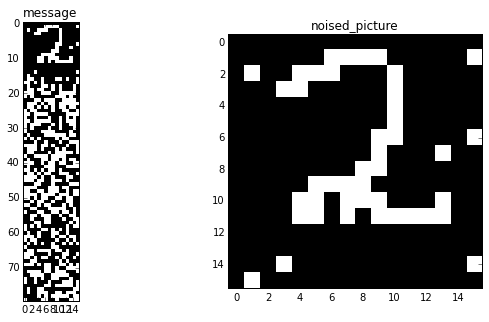

In [85]:
q = 0.05
v_noised = (v + get_noise(len(v), q)) % 2

v_show_indeces = list(G[1]) + [item for item in range(5*l) if item not in G[1]]
v_show = v_noised[v_show_indeces]

show_pic([v_show.reshape((len(v)/16, 16)), v_show[0:256].reshape((16, 16))], ["message", "noised_picture"], (10,5))

## 2.4 Последовательное декодирование

In [86]:
res = decode(H.dot(v_noised) % 2, H, q)
print res[1], sum(res[0])

1 58


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


4


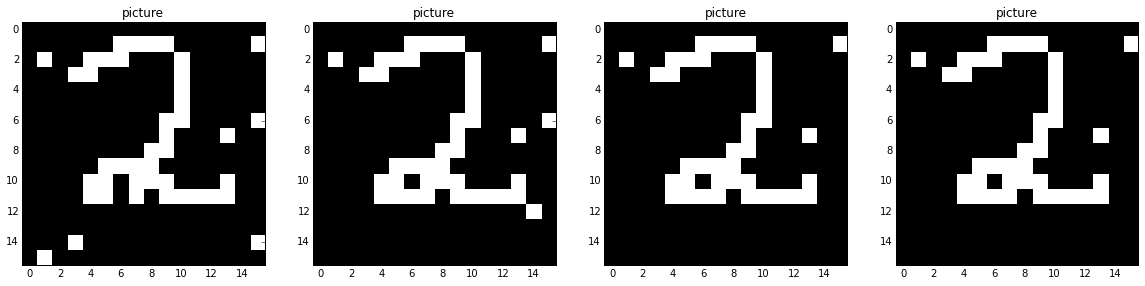

In [87]:
progress = [v_noised[v_show_indeces][0:256].reshape((16, 16))]
progress += [((v_noised + res[2][3*i])%2)[v_show_indeces][0:256].reshape((16, 16)) for i in range(len(res[2])/3)]
progress += [((v_noised + res[2][len(res[2]) - 1])%2)[v_show_indeces][0:256].reshape((16, 16))]
print len(progress)
show_pic(progress)

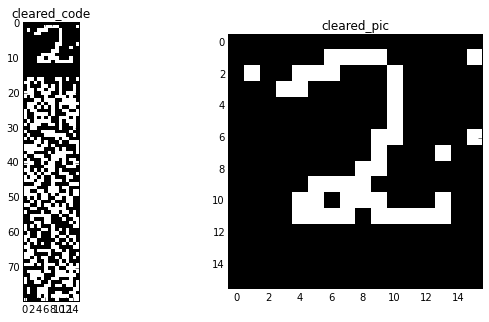

In [88]:
v_show = ((v_noised + res[2][1])%2)[v_show_indeces]

show_pic([v_show.reshape((len(v)/16, 16)), v_show[0:256].reshape((16, 16))], ["cleared_code", "cleared_pic"], (10, 5))

In [89]:
print sum((v + res[0] + v_noised) % 2)

5.0


# 3. Эксперименты с различными расписаниями пересчёта сообщений и коэффициентами дэмпфирования

## 3.1 Доля стабилизировавшихся beliefs в зависимости от номера итерации алгоритма декодирования

In [152]:
H = generate_H(500, 600)

По идее правильнее было бы для каждого вектора ошибок и синдрома запускать все возможные расписания и коэффициенты дэмпфирования, но т.к. число испытаний высоко, то этим можно пренебречь, а с точки зрения стиля кода, реализация, приведенная ниже смотрится лучше

In [177]:
def get_mean_stable_beliefs_rate(H, test_number = 20):
    schedules = ["sequential", "parallel"]
    dampings = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    scheme_rate = dict()
    scheme_time = dict()
    
    for schedule in schedules:
        for damping in dampings:
            t = time.time()
            buf = []
            for i in range(test_number):
                e = get_noise(H.shape[1], 0.03)
                s = H.dot(e) % 2
                _, status, _, stable_beliefs_rate = decode(s, H, q, schedule, damping)
                buf.append(stable_beliefs_rate)
        
            lens = [len(buf[i]) for i in range(test_number)]
            max_len = np.max(lens)

            for i in range(test_number):
                buf[i] += [1.0]*(max_len - lens[i])

            buf = np.array(buf)
            res = np.mean(buf, axis = 0)
            scheme_time[schedule, damping] = time.time() - t
            scheme_rate[schedule, damping] = res
                
    return scheme_rate, scheme_time

In [178]:
r = get_mean_stable_beliefs_rate(H)

0 1
1 1
2 0
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 0
15 1
16 1
17 1
18 1
19 1
[20, 18, 6, 19, 19, 31, 18, 18, 7, 18, 21, 19, 18, 18, 6, 18, 18, 19, 18, 18]
0 1
1 0
2 1
3 1
4 0
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 0
16 1
17 1
18 1
19 1
[14, 4, 23, 14, 5, 8, 17, 16, 17, 8, 14, 14, 14, 14, 14, 4, 14, 14, 14, 8]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 0
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
[11, 11, 18, 11, 13, 12, 11, 4, 11, 11, 11, 11, 11, 11, 12, 13, 11, 5, 11, 11]
0 1
1 1
2 1
3 1
4 0
5 1
6 0
7 1
8 1
9 0
10 0
11 1
12 1
13 1
14 0
15 1
16 1
17 0
18 1
19 1
[9, 9, 10, 14, 3, 9, 3, 9, 9, 3, 3, 10, 9, 10, 4, 9, 9, 1, 9, 5]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 0
10 1
11 1
12 1
13 0
14 1
15 1
16 1
17 1
18 1
19 1
[8, 7, 11, 7, 8, 3, 7, 3, 7, 3, 7, 7, 7, 3, 7, 7, 8, 7, 7, 7]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 0
8 1
9 1
10 0
11 0
12 1
13 1
14 0
15 0
16 1
17 1
18 1
19 1
[7, 7, 4, 7, 6, 6, 6, 2, 6, 6, 2, 2, 6, 6, 2, 1, 6, 6, 6, 6]
0 0
1 0
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1


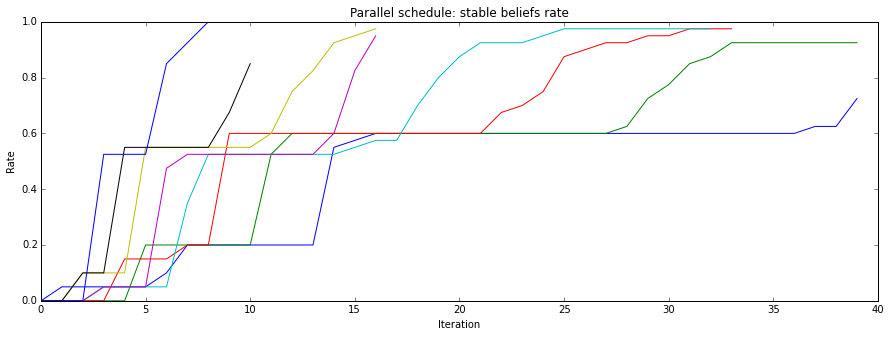

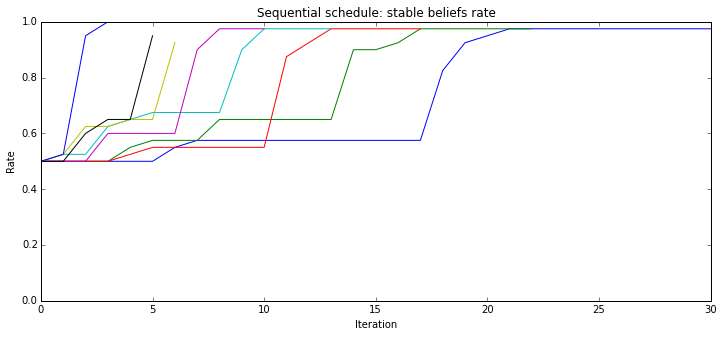

In [214]:
dampings = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

plt.figure(figsize=(15, 5))
plt.title("Parallel schedule: stable beliefs rate")
plt.xlabel("Iteration")
plt.ylabel("Rate")
for key in dampings:
    plt.plot(r[0][('parallel', key)], label=key)
    
plt.figure(figsize=(12, 5))
plt.title("Sequential schedule: stable beliefs rate")
plt.xlabel("Iteration")
plt.ylabel("Rate")
plt.ylim(0.0, 1.0)
for key in dampings:
    plt.plot(r[0][('sequential', key)], label=key)

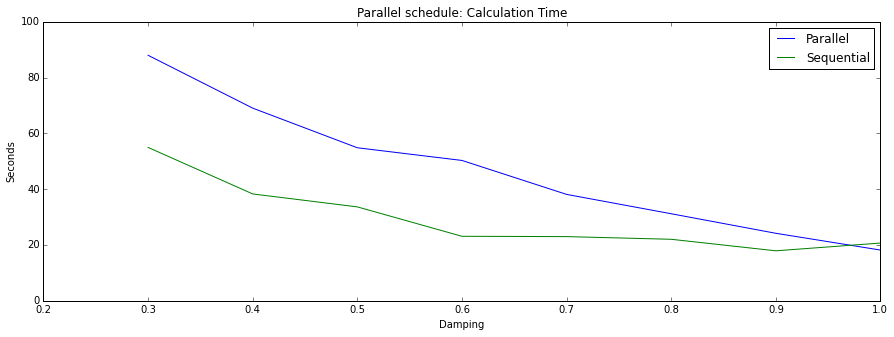

In [251]:
dampings = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

times_seq = []
times_par = []
for key in sorted(r[1]):
    if (key[0] == 'parallel'):
        times_par.append(r[1][key])
    else:    
        times_seq.append(r[1][key])

plt.figure(figsize=(15, 5))
plt.title("Calculation Time")
plt.xlabel("Damping")
plt.ylabel("Seconds")
plt.ylim(0.0, 100.0)
plt.plot(dampings, times_par, label = 'Parallel')
plt.plot(dampings, times_seq, label = 'Sequential')

plt.legend(loc='best')

## 3.2 Вывод о производительности

Параллельное расписание оказалось немного медленнее при малом коэффициенте дэмпфирования, разница почти пропадает при отсутсивии дэмпфирования. Проводились тесты с другими данными. Последовательное расписание всегда оказывалось быстрее. По виду графиков в незначительную константу раз (1.2 - 2.5)  
Дэмпфирование очевидным образом замедляет процесс сходимости

# 4. Проверка качества кода на ошибки

In [256]:
def estimate_errors(H, q, num_points = 40):
    success = 0.0
    err_bit = 0.0
    err_block = 0.0
    
    row_number, column_number = H.shape
    
    for i in range(num_points):
        e = get_noise(column_number, q)
        s = H.dot(e) % 2
        e_decoding, status, _, _ = decode(s, H, q)
        if status < 2:
            err_block += 1 - np.all(e_decoding == e)
            err_bit += np.sum(e_decoding != e) * 1.0 / column_number
            success += 1
        
    diver = (num_points - success) / num_points
    err_bit /= success
    err_block /= success
    
    return err_bit, err_block, diver

In [257]:
estimate_errors(H, 0.1)

(0.0059166666666666656, 0.95, 0.0)

# 5. Проверка прикладной пользы теоремы Шеннона

## 5.1 Изменение характеристик кода при различных скоростях $r$

In [259]:
qs = [0.01, 0.05, 0.1, 0.2]
n = 1000
errors = dict()
for q in qs:
    errors[q] = []
    for k in range(1, n+1, 100):
        H = generate_H(n-k, n)
        print k
        errors[q].append(estimate_errors(H, q))
        
block_errors = dict()
bit_errors = dict()
for q in qs:
    block_errors[q] = [errors[q][k][1] for k in range(len(errors[q]))]
    bit_errors[q] = [errors[q][k][0] for k in range(len(errors[q]))]

1
101
201
301
401
501
601
701
801
901
1
101
201
301
401
501
601
701
801
901
1
101
201
301
401
501
601
701
801
901
1
101
201
301
401
501
601
701
801
901


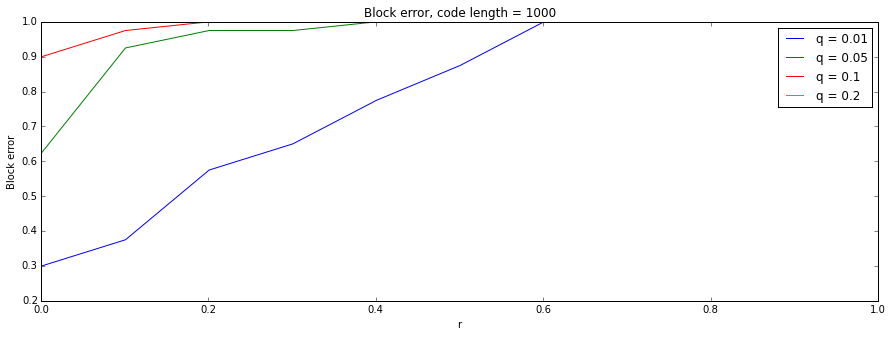

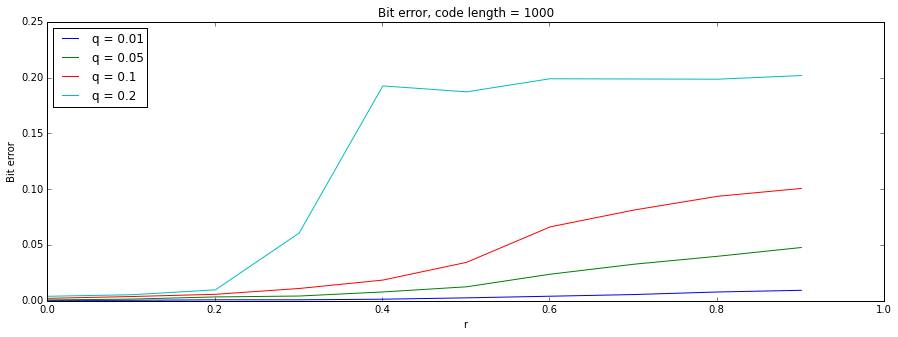

In [288]:
x_coords = np.array(range(1, n+1, 100)) / 1000.0

plt.figure(figsize=(15, 5))
plt.title("Block error, code length = 1000")
plt.xlabel("r")
plt.ylabel("Block error")
for q in qs:
    plt.plot(x_coords, block_errors[q], label="q = " + str(q))
plt.legend(loc='best')

plt.figure(figsize=(15, 5))
plt.title("Bit error, code length = 1000")
plt.xlabel("r")
plt.ylabel("Bit error")

for q in qs:
    plt.plot(x_coords, bit_errors[q], label="q = " + str(q))
plt.legend(loc='best')

Как и ожидалсь: чем выше скорость кода, тем больше ошибок не исправляется

## 5.2 Проверим, что качество кода растет при увеличении длины кодового слова $n$, при фиксированной скорости $r$.

In [264]:
r = 0.5
errors_fixed_speed = dict()
for q in qs:
    errors_fixed_speed[q] = list()
    print q
    for n in range(101, 1000, 100):
        H = generate_H(n - int(r*n), n)
        if n % 100 == 0:
            print "n = ", n, "q = ", q
        errors_fixed_speed[q].append(estimate_errors(H, q))

0.01
0.05
0.1
0.2


In [289]:
block_errors_fs = dict()
bit_errors_fs = dict()
for q in qs:
    block_errors_fs[q] = [errors_fixed_speed[q][k][1] for k in range(len(errors_fixed_speed[q]))]
    bit_errors_fs[q] = [errors_fixed_speed[q][k][0] for k in range(len(errors_fixed_speed[q]))]

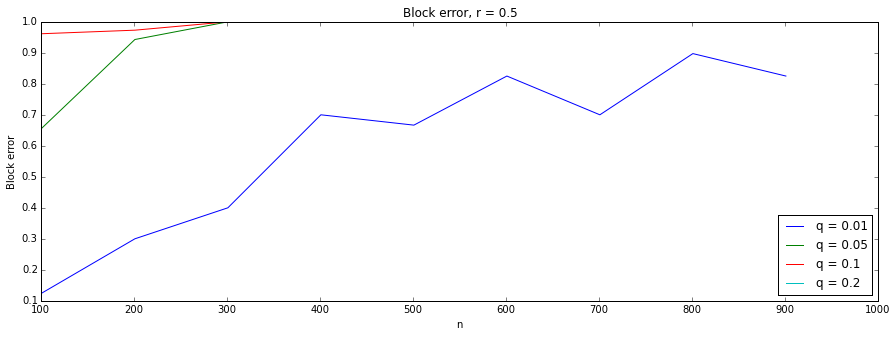

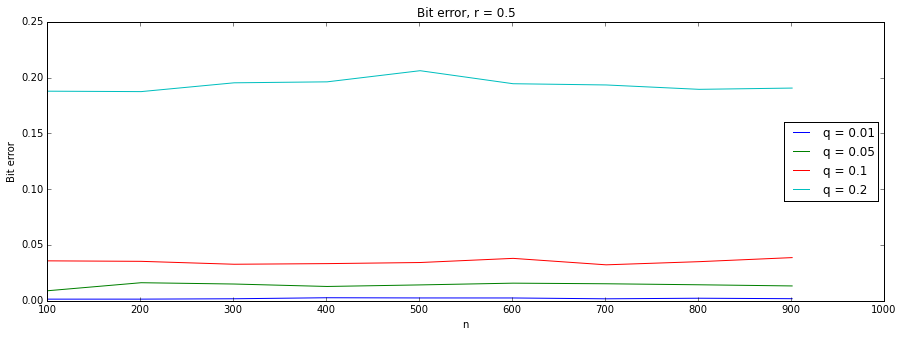

In [291]:
x_coords_fs = range(101, 1000, 100)

plt.figure(figsize=(15, 5))
plt.title("Block error, r = 0.5")
plt.xlabel("n")
plt.ylabel("Block error")
for q in qs:
    plt.plot(x_coords_fs, block_errors_fs[q], label="q = " + str(q))
plt.legend(loc='best')

plt.figure(figsize=(15, 5))
plt.title("Bit error, r = 0.5")
plt.xlabel("n")
plt.ylabel("Bit error")

for q in qs:
    plt.plot(x_coords_fs, bit_errors_fs[q], label="q = " + str(q))
plt.legend(loc='best')

Блоковая ошибка растет, так как чем больше блок, тем больше вероятность совешить хотя бы где-то ошибку.  
С битовой ошибкой изменений вроде бы нет, но хочется посмотреть на совсем малых блоках и на других скоростях кода.

In [303]:
r = 0.7
errors_fixed_speed_low_n = dict()
for q in qs:
    errors_fixed_speed_low_n[q] = list()
    print q
    for n in range(3, 100, 5):
        H = generate_H(n - int(r*n), n)
        if n % 100 == 0:
            print "n = ", n, "q = ", q
        errors_fixed_speed_low_n[q].append(estimate_errors(H, q))

0.01
0.05
0.1
0.2


In [304]:
block_errors_fs_low_n = dict()
bit_errors_fs_low_n = dict()
for q in qs:
    block_errors_fs_low_n[q] = [errors_fixed_speed_low_n[q][k][1] for k in range(len(errors_fixed_speed_low_n[q]))]
    bit_errors_fs_low_n[q] = [errors_fixed_speed_low_n[q][k][0] for k in range(len(errors_fixed_speed_low_n[q]))]

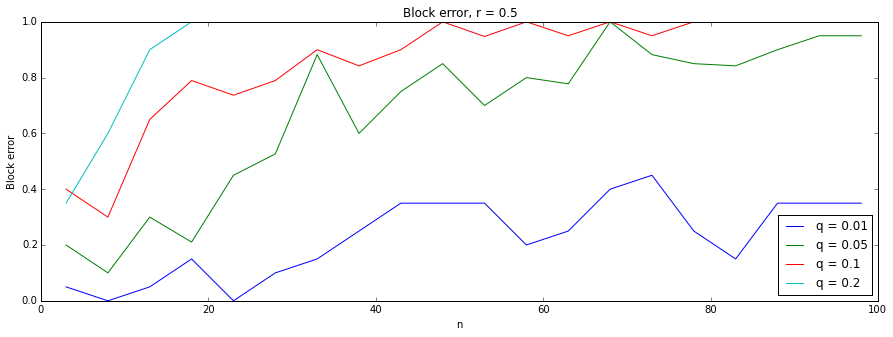

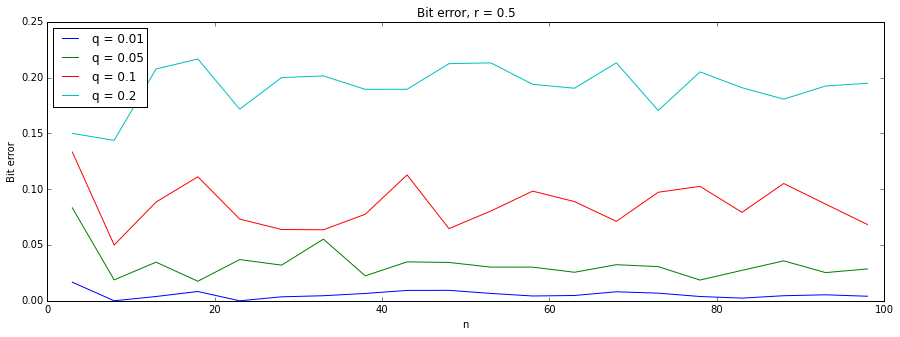

In [305]:
x_coords_fs_low_n = range(3, 100, 5)

plt.figure(figsize=(15, 5))
plt.title("Block error, r = " + str(r))
plt.xlabel("n")
plt.ylabel("Block error")
for q in qs:
    plt.plot(x_coords_fs_low_n, block_errors_fs_low_n[q], label="q = " + str(q))
plt.legend(loc='best')

plt.figure(figsize=(15, 5))
plt.title("Bit error, r = " + str(r))
plt.xlabel("n")
plt.ylabel("Bit error")

for q in qs:
    plt.plot(x_coords_fs_low_n, bit_errors_fs_low_n[q], label="q = " + str(q))
plt.legend(loc='best')

Эффект тот же. Брались более быстрые коды, брались блоки различной длины. Лишь иногда было незначительное уменьшение битовой ошибки

## 5.3 Проверим, что качество кода растет при увеличении среднего количества единиц в столбце проверочной матрицы $j$.

In [310]:
errors_H_ones = dict()
for q in qs:
    errors_H_ones[q] = list()
    print q
    for j in range(3, 30, 6):
        H = generate_H(50, 100, j)
        errors_H_ones[q].append(estimate_errors(H, q))

0.01
3
9
15
21
27
0.05
3
9
15
21
27
0.1
3
9
15
21
27
0.2
3
9
15
21
27


In [311]:
block_errors_H_ones = dict()
bit_errors_H_ones = dict()
for q in qs:
    block_errors_H_ones[q] = [errors_H_ones[q][k][1] for k in range(len(errors_H_ones[q]))]
    bit_errors_H_ones[q] = [errors_H_ones[q][k][0] for k in range(len(errors_H_ones[q]))]

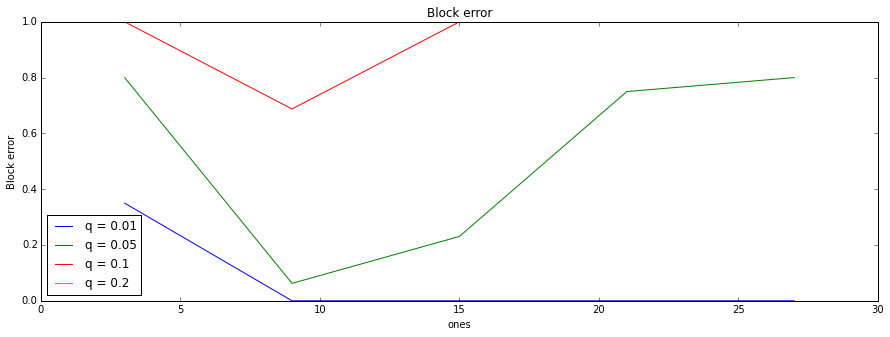

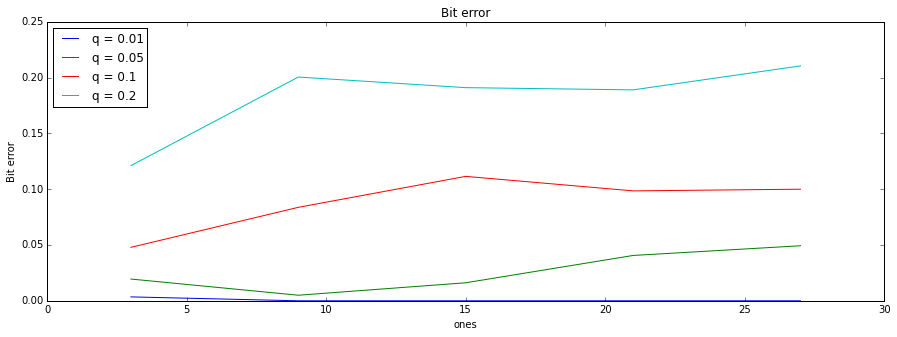

In [314]:
x_coords_H_ones = range(3, 30, 6)

plt.figure(figsize=(15, 5))
plt.title("Block error")
plt.xlabel("ones")
plt.ylabel("Block error")
for q in qs:
    plt.plot(x_coords_H_ones, block_errors_H_ones[q], label="q = " + str(q))
plt.legend(loc='best')

plt.figure(figsize=(15, 5))
plt.title("Bit error")
plt.xlabel("ones")
plt.ylabel("Bit error")

for q in qs:
    plt.plot(x_coords_H_ones, bit_errors_H_ones[q], label="q = " + str(q))
plt.legend(loc='best')